# Intoduccion

El siguiente proyecto tiene por objetivo el uso de ***redes neuronales*** con el fin de realizar clasificacion de texto y reconocer entidades cubanas. Con entidades cubanas nos referimos a cualquier ente que pertenezca a Cuba, pueden ser desde animales autoctonos, instituciones, personas, marcas de empresas, productos, platos gastronomicos, etc. cualquier cosa que lleve el sello de cubania, la idea es decir si es una entidad cubana y de que tipo. Las entidades cubanas se encuentran en el texto en forma de frases, por ejemplo: Jose Marti, Republica de Cuba, etc. Entre los tipos de entidades cubanas se encuentran *ley*, *organizacion*, *persona*, etc., el tipo *otro* es utilizado para clasificar cualquier palabra no relacionada con una entidad cubana. Como se puede apreciar tal tarea es casi imposible de cometer, principalmente por el tamano del espacio de entidades cubanas y los distintos tipos de las mismas, clasificar todas las entidades cubanas en texto es una tarea titanica, no digamos ya crear un buen clasificador. Sin embargo, en este proyecto intentamos, con un dataset bastante modesto, realizar ese objetivo. Se probaron varios modelos, los cuales veremos desde el mas simple hasta el mas complejo que es el estado del arte.

# Baseline

El primer modelo es un *baseline*, la idea es crear un clasificador que dado el trainset, le asignara a cada palabra la categoria en la que esta aparezca mas, posteriormente para clasificar el testset, si la palabra se encuentra almacenada y clasificada con la categoria en la que mas se repite en el trainset, se devuelve esta categoria, si no se devuelve la categoria de palabra que no pertenece a entidades cubanas, es decir *otro*.

In [1]:
import sklearn.base
from sklearn.metrics import f1_score, make_scorer, precision_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import to_categorical
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import scipy.stats
from typing import List, Tuple, Dict, Any
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from typing import Iterator, Tuple, List, Dict
from keras.models import Model, Input

Using TensorFlow backend.


Simple metodo que lee el dataset y lo devuelve.

In [2]:
def read_tsv(name: str):
	data = None
	with open(name, 'r', encoding='utf-8') as file:
		data = file.read()
	return data

Metodo que transforma de la representacion del dataset a una representacion **[BIO][1]**, la representacion **BIO** debe su nombre a *begin*, *inside*, *outside*, la idea es poder conocer que frases de un texto son consideradas entidades cubanas, en este caso la primera palabra de la frase sera *taggeada* (del spanglish *taggear* que se deriba del ingles *tag* y tiene por significado categorizar, clasificar, marcar, etc.) de *begin* y las restantes palabras que se encuentren en la frase seran *taggueadas* de *inside*. De esta forma, por ejemplo, las palabras de una organizacion como pudiera ser **Union de Jovenes Comunistas**, terminaria con las palabras categorizadas del siguiente modo: `Union:begin-ORG`, `de:in-ORG`, `Jovenes:in-ORG`, `Comunistas:in-ORG`. En donde *ORG* se refiere a organizacion, de esta forma podemos conocer que esta entidad es cubana y es una organizacion. Esta forma de clasificar tiene la ventaja de permitirnos conocer donde inicia, termina y las palabras internas de una entidad.

[1]: https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

In [3]:
def transform_tsv2BIO(name: str) -> Tuple[List[str], List[str]]:
	words = []
	tags = []
	actual: str = ''
	with open(name, 'r', encoding='utf-8') as file:
		for item in file.readlines():
			word: str
			tag: str
			word, tag = item.replace('\n', '').split('\t')
			if tag != 'O':
				words_in = word.split()
				words.append(words_in.pop(0))
				tags.append(f'B-{tag}')
				for word_in in words_in:
					words.append(word_in)
					tags.append(f'I-{tag}')
			else:
				words.append(word)
				tags.append(tag)

	return words, tags

Dado un texto como una sola cadena lo divide en oraciones por los puntos. Tambien utilizado para dividir el texto por cantidad de oraciones, util para transformar la cadena del texto en trainset y testset.

In [4]:
class SentenceGetter:

	def __init__(self, **kwargs):
		if kwargs.get('words', False):
			self.text = self.to_sentences(kwargs['words'])
		else: raise Exception('incorrect arguments')

	@staticmethod
	def to_sentences(sents: List[str]) -> List[List[str]]:
		resp = []
		sents_cop = sents
		for times in range(sents.count('.')):
			part = sents_cop[: sents_cop.index('.') + 1]
			resp.append(part)
			sents_cop = sents_cop[sents_cop.index('.') + 1:]
		return resp

	def split(self, number: int) -> Tuple[List[str], List[str]]:
		part1, part2 = self.text[: number], self.text[number:]
		t1 = []
		ret1 = [t1.extend(ls) for ls in part1][0]
		t2 = []
		ret2 = [t2.extend(ls) for ls in part2][0]

		return t1, t2

In [5]:
def to_tags(vectors, tags_index: dict):
	vektor = list(vectors)
	tags = []
	index2tags = {value: key for key, value in tags_index.items()}
	for sentence in vektor:
		sent = []
		for vec in sentence:
			sent.append(index2tags[list(vec).index(1.0)])
		tags.append(sent)

	new_tags = []

	for el in tags:
		new_tags.extend(el)

	return new_tags

Clase encargada de, como se hablo al inicio de la seccion, clasificar las palabras. El *baseline* en si mismo.

In [6]:
class MemoryTagger(sklearn.base.BaseEstimator):

	def fit(self, X, y):
		'''
		Expects a list of words as X and a list of tags as y.
		'''
		voc = {}
		self.tags = []
		for x, t in zip(X, y):
			if t not in self.tags:
				self.tags.append(t)
			if x in voc:
				if t in voc[x]:
					voc[x][t] += 1
				else:
					voc[x][t] = 1
			else:
				voc[x] = {t: 1}
		self.memory = {}
		for k, d in voc.items():
			self.memory[k] = max(d, key=d.get)

	def predict(self, X, y=None):
		'''
		Predict the the tag from memory. If word is unknown, predict 'O'.
		'''
		return [self.memory.get(x, 'O') for x in X]

Se carga el *corpus* (texto clasificado) y lo dividimos en trainset y testset, para el testset utilizaremos las palabras de las ultimas 20 oraciones. Uitlizaremos las ultimas 20 oraciones por ser el dataset bastante pequeno.

In [7]:
words, tags = transform_tsv2BIO('code/corpus.tsv')

all_words = list(set(words))
all_tags = list(set(tags))

n_words = len(all_words)
n_tags = len(all_tags)

sent_get = SentenceGetter(words=words)
w_train, w_test = sent_get.split(-20)
t_train, t_test = tags[:len(w_train)], tags[len(w_train):]

El clasificador *baseline* en accion. Notemos que su presicion es bastante buena, esto debido a que el *corpus* (dataset) es bastante pequeno.

In [8]:
model = MemoryTagger()
model.fit(w_train, t_train)

pred = model.predict(w_test)

print(precision_score(t_test, pred, average='weighted'))

0.9105711385651969
/usr/local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


# Conditional Random Fields

[Conditional Random Fields][1] (crf) fue una tecnica muy utilizada en procesamiento de lenguaje natural y clasificacion de textos antes de que se extendiera el uso de las redes neuronales, aun puede verse esta tecnica comparandose con el estado del arte. Para aplicarla al problema que tenemos creamos una representacion vectorial de las palabras utilizando caracteristicas de la palabra en si misma asi como de las palabras circundantes, de esta forma el modelo *aprende* del contexto.

[1]: https://en.wikipedia.org/wiki/Conditional_random_field

In [9]:
sentence = List[str]

In [10]:
def word2features(sent: sentence, i: int) -> Dict:

	word = sent[i]

	features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
	if i > 0:
		word1 = sent[i - 1]
		features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
		})
	else:
		features['BOS'] = True

	if i < len(sent) - 1:
		word1 = sent[i + 1]
		features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
	else:
		features['EOS'] = True

	return features

Transformamos el dataset en estos *feature vectors* o vectores de caracteristicas.

In [11]:
def sent2features(sent: sentence):
	return [word2features(sent, i) for i in range(len(sent))]

Entrenamos el modelo y vemos su comportamiento.

In [12]:
w_train_f = sent2features(w_train)
w_test_f = sent2features(w_test)

crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1,
						   max_iterations=100, all_possible_transitions=True
)

doc_train_f = [w_train_f]
doc_train_t = [t_train]
 
crf.fit(doc_train_f, doc_train_t)

pred = crf.predict_single(w_test_f)

In [13]:
print(f1_score(t_test, pred, average='weighted'))

0.9295307874852416
/usr/local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


Podemos ver que la medida *f1* es bastante buena, debido, nuevamente, como ya se dijo, a que el *corpus* es bastante pequeno.

> Ejercicio: realizar una busqueda sobre los hyperparametros *C1* y *C2* para mejorar las predicciones. 
[ver ejemplo][1]
[1]: https://github.com/rayniel95/Clasificador-de-Anuncios-Luis-Alberto-Diaz-Alejandro-Ramirez-Frank-Elier-Rainyel-Ramos

> Ejercicio: probar agregando otras caracteristicas o mas caracteristicas del mismo tipo como bien pudiera ser dos o mas palabras circundantes y caracteristicas especificas de estas.

# Conditional Random Fields usando Embedding

Para nadie es un secreto que la representacion vectorial de las palabras en *[embedding][2]* a revolucionado el campo del procesamiento del lenguaje natural o procesamiento de texto. Una tecnica que se utilizo por pensarse que podria dar resultados fue el uso de los *word embedding* como vectores de caracteristicas para un crf.

[2]: https://en.wikipedia.org/wiki/Word_embedding

Creamos el modelo, una capa de embedding encargada de llevar nuestros vectores a otro espacio acorde a las relaciones de contexto de las palabras, anterior a una capa crf.

In [14]:
def make_crf_embedding_model():
	model = Sequential()
	model.add(Embedding(input_dim=n_words + 1, output_dim=20,
						input_length=max_len))

	crf = CRF(n_tags)
	model.add(crf)

	model.compile('adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
	return model

Se realiza la preparacion de los datos, o sea, transformaremos los datos en vectores de caracteristicas utiles a la capa de *embedding*. Para ello enumeramos cada palabra (las redes neuronales solo admiten vectores numericos como entrada), posteriormente dividimos el dataset en oraciones, donde cada oracion sera un vector de caracteristicas y cada componente i-esimo del mismo el numero asignado a la palabra i-esima en la oracion. Asumiendo que la oracion mas larga no tiene mas de 75 palabras (esto es cierto dado el dataset que tenemos) debemos, a fin de que todos los vectores tengan la misma longitud, rellenar con un numero especial a aquellos que no alcancen esta longitud. La idea de utilizar las oraciones como los vectores de caracteristicas parte de que de esta forma la capa de embedding podra encontrar las relaciones que se establecen entre cada palabra y las que la rodean en la misma oracion.

Como se dijo anteriormente asignamos un numero a cada palabra.

In [15]:
max_len = 75
word2dix = {w: i + 1 for i, w in enumerate(all_words)}
tag2dix = {t: i for i, t in enumerate(all_tags)}

Dividimos el dataset en oraciones.

In [16]:
data_sent_w = sent_get.text

data_sent_t = [[tags.pop(0) for _ in sent] for sent in data_sent_w]

Rellenamos aquellos vectores cuyas longitudes sean menores a 75. Son rellenados con el valor asignado a la categoria *otro*.

In [17]:
data_features = [[word2dix[word] for word in sent] for sent in data_sent_w]
data_features = pad_sequences(truncating='post', maxlen=max_len, 												  sequences=data_features, padding='post', 											  value=n_words-1)

data_tags = [[tag2dix[tag] for tag in sent] for sent in data_sent_t]
data_tags = pad_sequences(maxlen=max_len, sequences=data_tags, truncating='post',
				  padding='post', value=tag2dix['O'])

Algo interesante a conocer es que la salida de una red neuronal es un vector numerico con componentes entre 0 y 1, por tanto cada categoria de palabra debe ser transformada en un vector numerico donde todas las componentes seran 0 exceptuando aquella a la que sera asignada la categoria la cual tendra valor de 1.

In [18]:
data_tags_cat = [to_categorical(tag, num_classes=n_tags) for tag in data_tags]

Dividimos el dataset en trainset y en testset dando al testset un 10*%* del total de oraciones.

In [19]:
features_tr, features_te, tags_tr, tags_te = train_test_split(data_features,                                                                   data_tags_cat,                                                                   test_size=0.1)

Creamos el modelo y lo entrenamos.

In [20]:
model = make_crf_embedding_model()

history = model.fit(features_tr, np.array(tags_tr), batch_size=32, epochs=500,
					validation_split=0.1, verbose=0)
pred = model.predict(features_te)

/usr/local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Los vectores predichos se transforman nuevamente en categorias.

In [21]:
pred2 = to_tags(pred, tag2dix)
tags_te2 = to_tags(tags_te, tag2dix)

Analizamos la presicion y el *f1*. Como podemos ver es mucho mejor que los anteriores.

In [22]:
print(precision_score(tags_te2, pred2, average='weighted'))
print(f1_score(tags_te2, pred2, average='weighted'))

0.9641110982141776
0.9666001716001716


Ploteamos las learning curves. Podemos ver que el modelo luego de un punto no es capaz de *aprender* nada mas, o sea, no mejora, esto es debido a que el dataset es bastante pequeno y ya el modelo extrajo toda la informacion necesaria, es mas, ha hecho *overfiting*.

     val_loss  val_crf_viterbi_accuracy      loss  crf_viterbi_accuracy
0    2.712465                  0.134074  2.738120              0.133056
1    2.672838                  0.141481  2.697820              0.138958
2    2.632872                  0.144444  2.656651              0.144375
3    2.591984                  0.151852  2.615334              0.151528
4    2.549680                  0.155556  2.572719              0.156181
..        ...                       ...       ...                   ...
495  0.131107                  0.965185 -0.029552              0.995417
496  0.130951                  0.965185 -0.029673              0.993264
497  0.130800                  0.965185 -0.029804              0.995417
498  0.130636                  0.965185 -0.029936              0.991111
499  0.130394                  0.965185 -0.030071              0.995486

[500 rows x 4 columns]


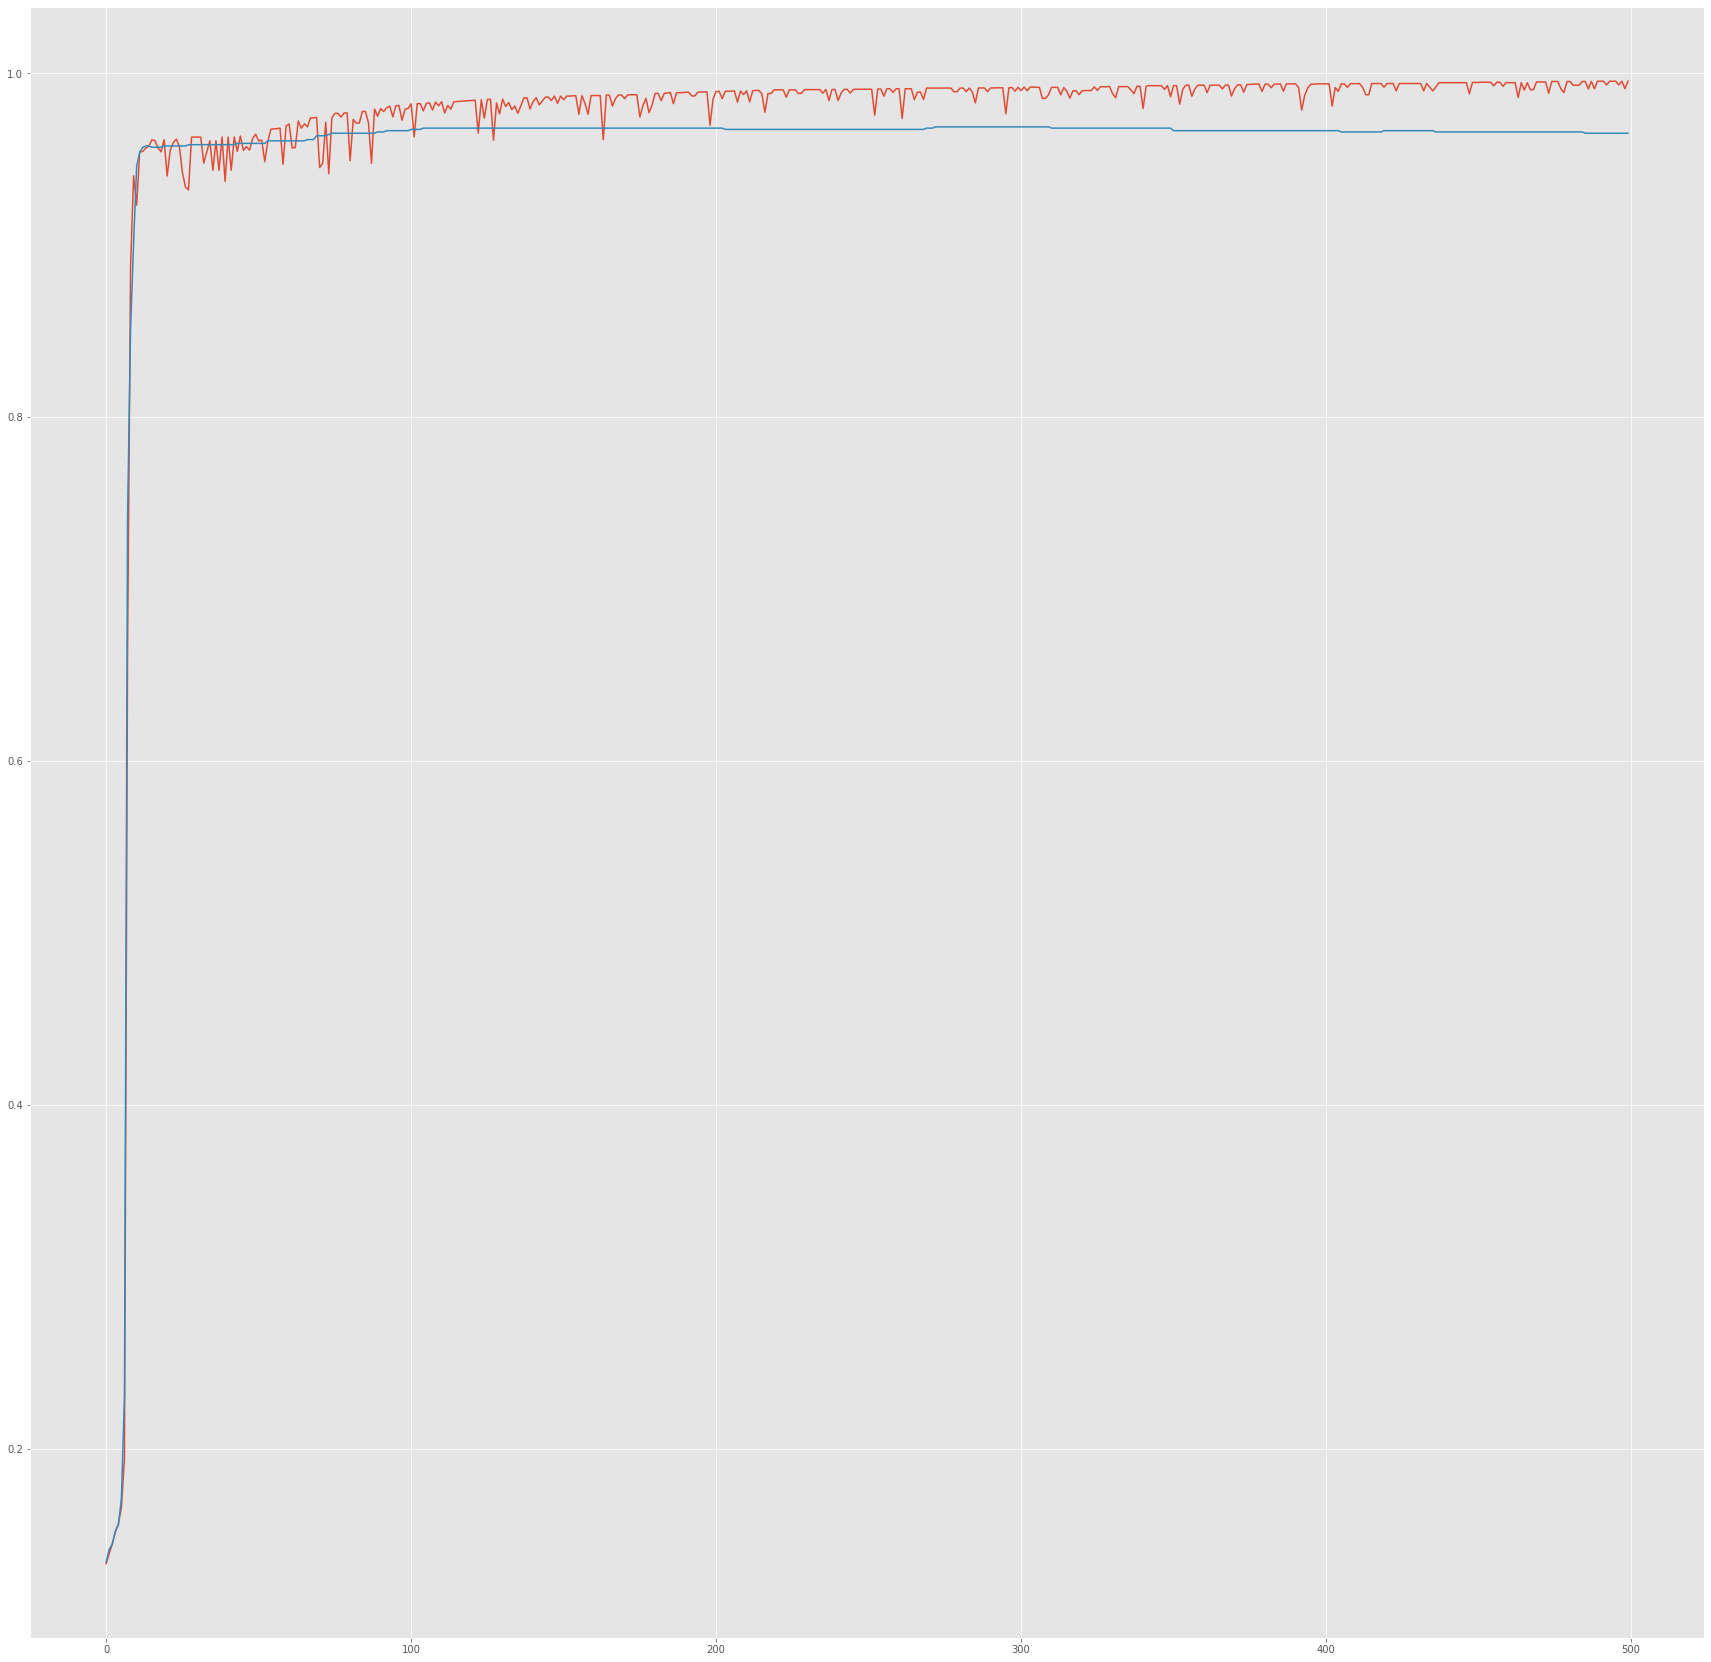

In [23]:
hist = pd.DataFrame(history.history)

print(hist)
plt.style.use("ggplot")
plt.figure(figsize=(30, 30,), )

plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])

plt.show()

# Long Short Term Memory

[Long Short Term Memory][3] es una arquitectura de red neuronal capaz de *recordar*, util para tratar secuencias. En este modelo extendemos el anterior, agregandole a la capa de embedding una capa *lstm* y luego una crf.

[3]: https://en.wikipedia.org/wiki/Long_short-term_memory

In [24]:
def make_lstm_model():
	input = Input(shape=(max_len,))
	model = Embedding(input_dim=n_words + 1, output_dim=20,
					  input_length=max_len)(input)
	model = Bidirectional(LSTM(units=50, return_sequences=True,
							   recurrent_dropout=0.1))(model)
	model = TimeDistributed(Dense(50, activation='relu'))(model)
	crf = CRF(n_tags)
	out = crf(model)

	model = Model(input, out)

	model.compile(optimizer="rmsprop", loss=crf.loss_function,
				  metrics=[crf.accuracy])
	return model

In [25]:
model = make_lstm_model()

history = model.fit(features_tr, np.array(tags_tr), batch_size=32, epochs=500,
					validation_split=0.1, verbose=0)

pred = model.predict(features_te)

pred2 = to_tags(pred, tag2dix)
y_te2 = to_tags(tags_te, tag2dix)

print(precision_score(y_te2, pred2, average='weighted'))
print(f1_score(y_te2, pred2, average='weighted'))

/usr/local/lib/python3.8/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.8/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/usr/local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
0.9591393104129619
0.9606252891387219
/usr/local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,
/usr/local/lib/python3

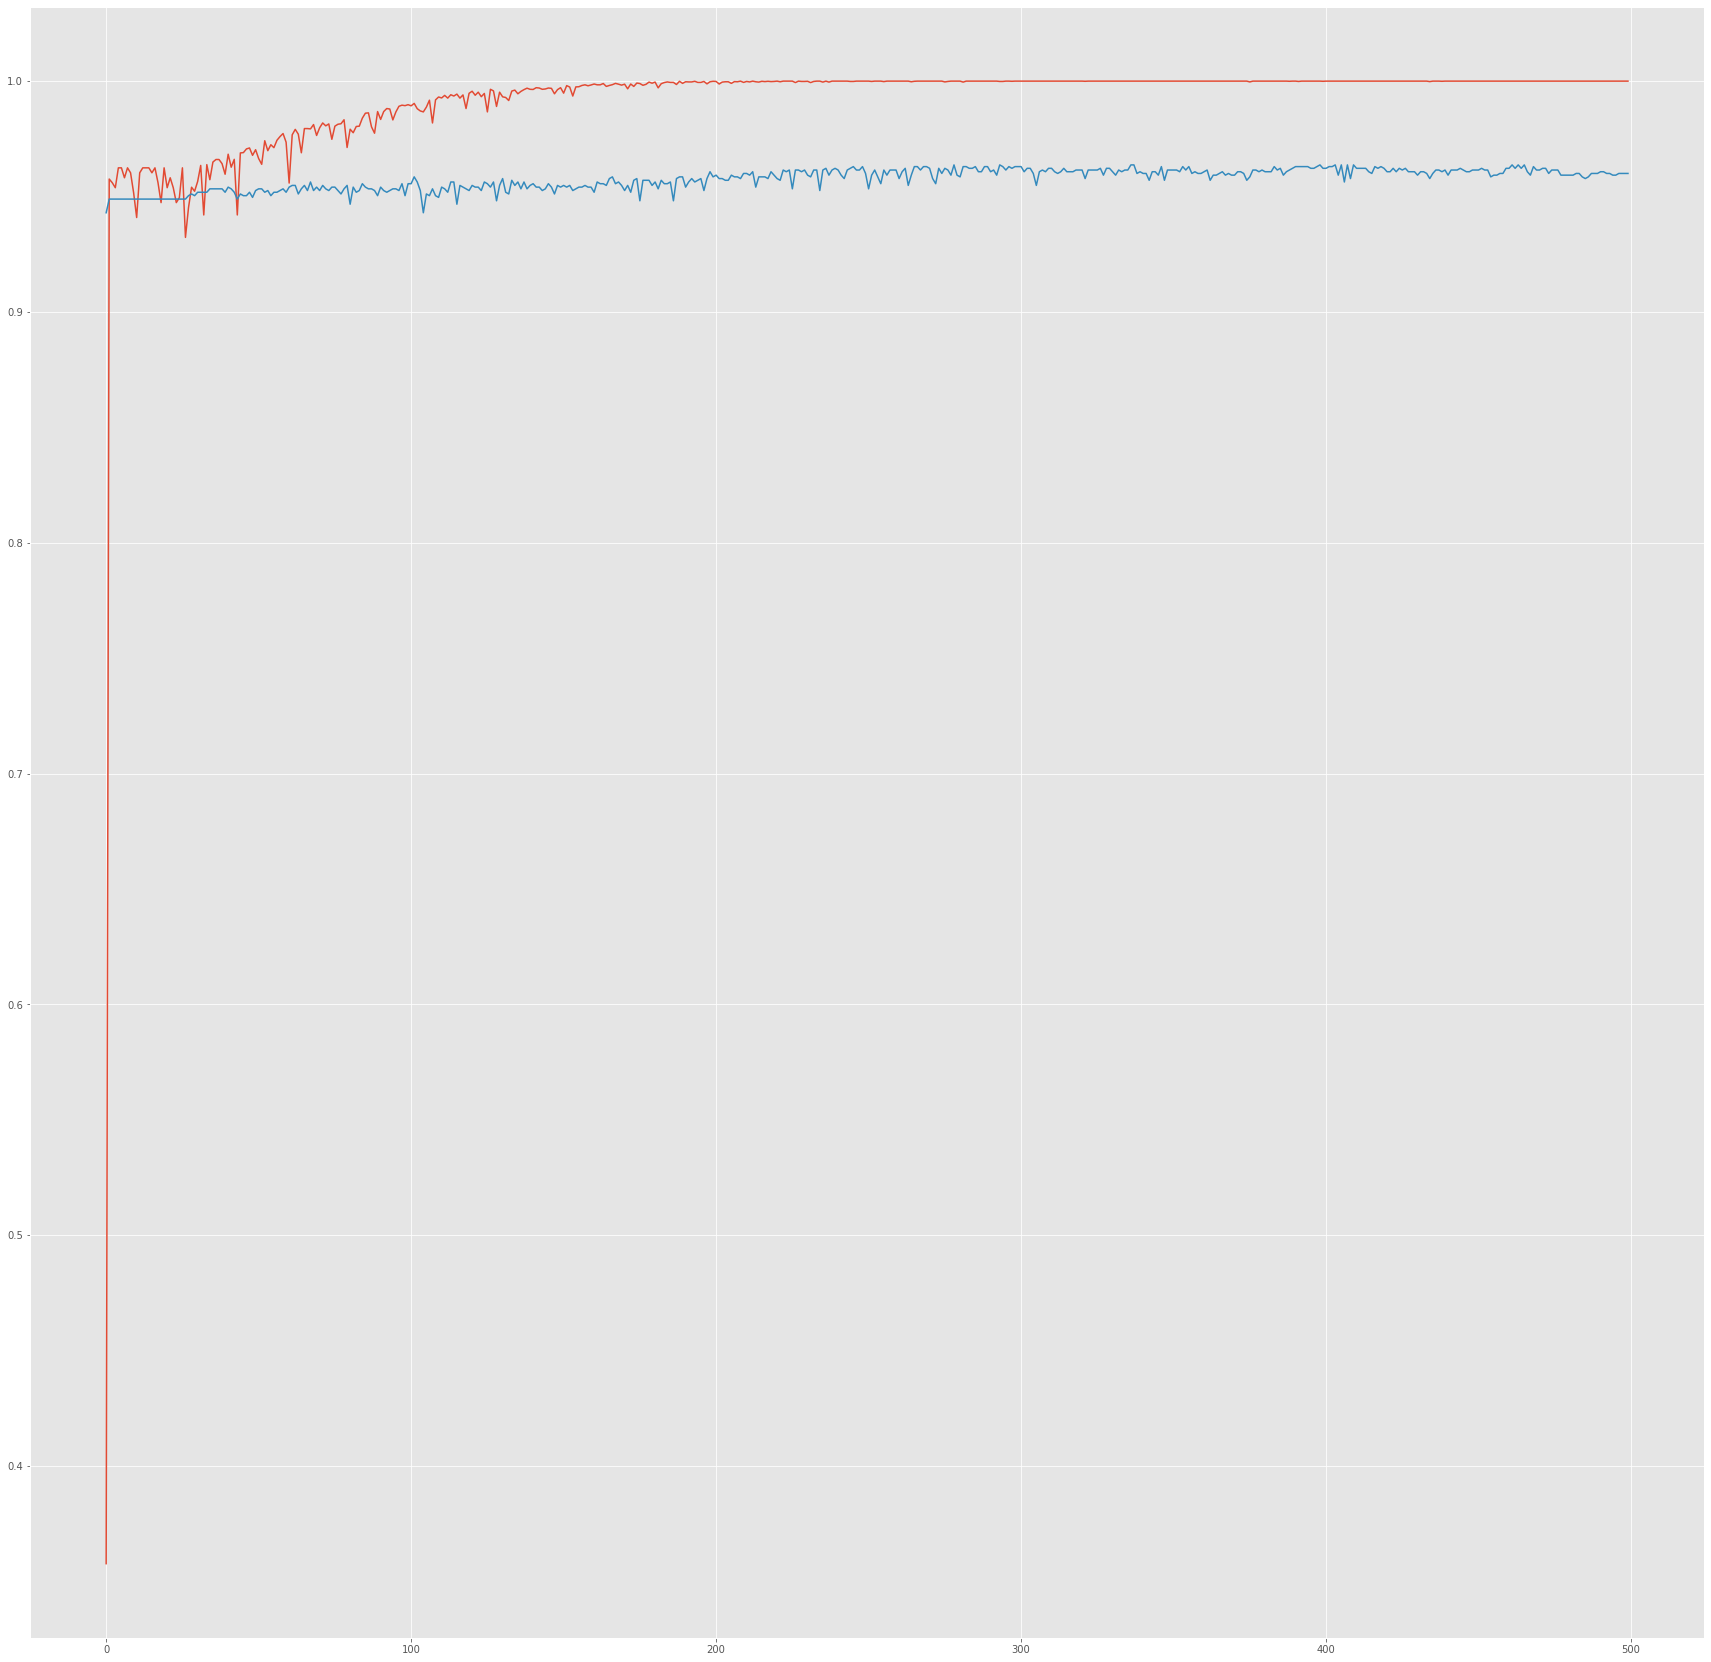

In [26]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(30, 30,))

plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])

plt.show()